In [3]:
import os
import sys
from copy import deepcopy

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from gymnasium.wrappers import RescaleAction
from torch import nn
from torch.distributions import Normal
from torch.optim import Adam

sys.path.append(os.path.abspath(".."))

from rlib.common.evaluation import get_trajectory, validation
from rlib.common.logger import Logger

%load_ext autoreload
%autoreload 2

In [2]:
env = gym.make("Pendulum-v1")

In [4]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)

### DDPG

In [5]:
class OrnsteinUhlenbeckNoise:
    def __init__(self, shape, alpha: float = 0.15, sigma: float = 0.2):
        self.shape = shape
        self.alpha = alpha
        self.sigma = sigma

        self.loc = torch.zeros(shape, dtype=torch.float32)
        self.scale = sigma * torch.ones(shape, dtype=torch.float32)
        self.dist = Normal(self.loc, self.scale)

        self.reset()

    def sample(self):
        self.state = self.alpha * self.state + self.dist.sample()
        return self.state

    def reset(self):
        self.state = torch.zeros(self.shape)

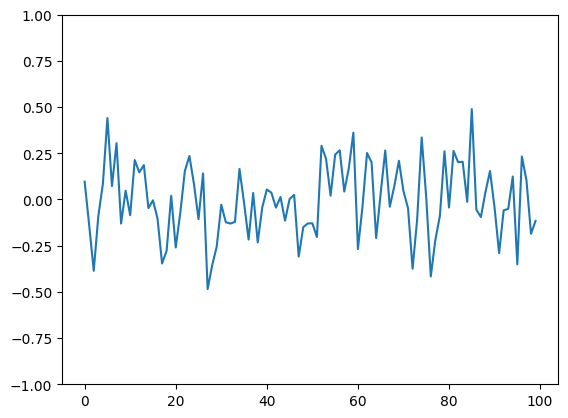

In [6]:
t = np.arange(100)
noise = np.zeros_like(t, dtype=np.float32)
ou_noise = OrnsteinUhlenbeckNoise((1,))

for i in range(t.size):
    noise[i] = ou_noise.sample().numpy()[0]

plt.ylim((-1, 1))
plt.plot(t, noise)

In [7]:
class DeterministicMlpPolicy(nn.Module):
    def __init__(
        self, obs_dim, action_dim, hidden_size=256, noise=OrnsteinUhlenbeckNoise
    ):
        super().__init__()
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.hidden_size = hidden_size

        self.shape = (1, self.action_dim)
        self.noise = noise(self.shape)

        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_dim),
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): (B, obs_dim)

        Returns:
            output: (torch.Tensor): (B, action_dim)
        """
        output = torch.tanh(self.net(input))
        return output

    def get_action(self, input, deterministic=False):
        """
        Args:
            input (torch.Tensor): (B, obs_dim)

        Returns:
            action: (torch.Tensor): (B, action_dim)
            log_prob_action: (torch.Tensor): (B, 1)
        """
        action = self.forward(input)

        if not deterministic:
            epsilon = self.noise.sample()
            action += epsilon

        return action

    def predict(self, observation, action=None, deterministic=False):
        """
        Called for env observation

        Args:
            observation (np.ndarray): (obs_dim,)

        Returns:
            action: (np.ndarray): (action_dim,)
            log_prob_action: (torch.Tensor): (1, 1)
        """

        expected_shape = (self.obs_dim,)
        if observation.shape != (self.obs_dim,):
            raise ValueError(
                f"Expected shape {expected_shape}, but got {observation.shape}"
            )

        input = torch.FloatTensor(observation.reshape(1, self.obs_dim))

        action = self.get_action(input, deterministic)
        action = action.detach().numpy()
        action = action.reshape((self.action_dim,))

        return action, {}

In [8]:
class MlpQCritic(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_size=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + action_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, observations, actions):
        """
        Args:
            observations (torch.Tensor): (B, obs_dim)
            actions (torch.Tensor): (B, action_dim)

        Returns:
            q_values: (torch.Tensor): (B, 1)
        """
        input = torch.cat((observations, actions), dim=1)
        return self.net(input)

In [9]:
class ReplayBuffer:
    def __init__(
        self,
        obs_dim,
        action_dim,
        max_size: int = 10000,
    ):
        self.max_size = max_size

        self.size = 0
        self.pointer = 0
        self.curr_obs = None

        self.observations = np.zeros((max_size, obs_dim))
        self.next_observations = np.zeros((max_size, obs_dim))
        self.actions = np.zeros((max_size, action_dim))
        self.rewards = np.zeros((max_size,))
        self.terminated = np.zeros((max_size,))
        self.truncated = np.zeros((max_size,))

    def add_transition(self, obs, next_obs, action, reward, terminated, truncated):
        self.observations[self.pointer] = obs
        self.next_observations[self.pointer] = next_obs
        self.actions[self.pointer] = action
        self.rewards[self.pointer] = reward
        self.terminated[self.pointer] = terminated
        self.truncated[self.pointer] = truncated

        self.pointer = (self.pointer + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def collect_transition(self, env, policy):
        if self.curr_obs is None:
            self.curr_obs, _ = env.reset()

        action, _ = policy.predict(self.curr_obs)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        self.add_transition(
            self.curr_obs, next_obs, action, reward, terminated, truncated
        )

        if terminated or truncated:
            next_obs, _ = env.reset()

        self.curr_obs = next_obs

    def get_batch(self, batch_size):
        assert self.size >= batch_size, "Batch size greater than buffer size"

        indices = np.random.choice(range(self.size), batch_size, replace=False)

        batch = {
            "observations": torch.tensor(
                self.observations[indices], dtype=torch.float32
            ),
            "next_observations": torch.tensor(
                self.next_observations[indices], dtype=torch.float32
            ),
            "actions": torch.tensor(self.actions[indices], dtype=torch.float32),
            "rewards": torch.tensor(self.rewards[indices], dtype=torch.float32),
            "terminated": torch.tensor(self.terminated[indices], dtype=torch.bool),
            "truncated": torch.tensor(self.truncated[indices], dtype=torch.bool),
        }

        return batch

    def get_last_trajectory(self):
        pass  # smth for logging

In [11]:
def ddpg_loss(data, actor, critic, actor_target, critic_target, gamma=0.99):
    loss = {}

    observations = data["observations"]

    actor_outputs = actor(observations)
    loss["actor"] = -critic(observations, actor_outputs).mean()

    actions = data["actions"]
    next_observations = data["next_observations"]
    rewards = data["rewards"].reshape(actor_outputs.shape)
    terminated = data["terminated"].reshape(actor_outputs.shape)

    with torch.no_grad():
        actions_target = actor_target(next_observations)
        targets = rewards + gamma * (~terminated) * critic_target(
            next_observations, actions_target
        )

    q_values = critic(observations, actions)
    loss["critic"] = ((q_values - targets) ** 2).mean()

    return loss

In [10]:
def smooth_update(model, target_model, tau: float = 0.99):
    for param, target_param in zip(model.parameters(), target_model.parameters()):
        new_terget_param = tau * target_param + (1 - tau) * param
        target_param.data.copy_(new_terget_param)

    return target_model

In [12]:
def ddpg(
    env,
    actor: DeterministicMlpPolicy,
    critic: MlpQCritic,
    actor_optimizer: Adam,
    critic_optimizer: Adam,
    training_starts: int = 1000,
    total_timesteps: int = 50_000,
    batch_size: int = 512,
    target_update_frequency: int = 50,
    verbose: bool = True,
):
    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    buffer = ReplayBuffer(obs_dim, action_dim)

    logger = Logger()

    actor_target = deepcopy(actor)
    critic_target = deepcopy(critic)

    steps_n = 0
    while steps_n < total_timesteps:
        buffer.collect_transition(env, actor)
        steps_n += 1

        if buffer.size < training_starts:
            continue

        batch = buffer.get_batch(batch_size)

        loss = ddpg_loss(batch, actor, critic, actor_target, critic_target)

        loss["actor"].backward()
        actor_optimizer.step()
        actor_optimizer.zero_grad()

        loss["critic"].backward()
        critic_optimizer.step()
        critic_optimizer.zero_grad()

        actor_target = smooth_update(actor, actor_target)
        critic_target = smooth_update(critic, critic_target)

        if verbose and steps_n % 10_000 == 0:
            trajectory = get_trajectory(env, actor)
            print(f"rewards: {sum(trajectory['rewards'])}")

        # logger.log(steps_n, batch)  # сюда не batch

In [13]:
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(obs_dim, action_dim)

3 1


In [39]:
actor = DeterministicMlpPolicy(obs_dim, action_dim)
critic = MlpQCritic(obs_dim, action_dim)

actor_optimizer = Adam(actor.parameters(), lr=1e-4)
critic_optimizer = Adam(critic.parameters(), lr=1e-3)

In [44]:
ddpg(env, actor, critic, actor_optimizer, critic_optimizer, total_timesteps=100_000)

rewards: -263.9329472090847
rewards: -329.11810541450376
rewards: -143.58301513955806
rewards: -27.06697322185902
rewards: -382.00178336924176
rewards: -513.9385961840351
rewards: -139.15223640429343
rewards: -136.52769555628223
rewards: -133.33613563519916
rewards: -512.0720746778412


In [48]:
validation(env, actor)

np.float64(-652.0478786855813)

### TD3

In [37]:
def td3_loss(
    data,
    actor,
    critic_1,
    critic_2,
    actor_target,
    critic_1_target,
    critic_2_target,
    gamma=0.99,
    policy_std=0.2,
    policy_clip=0.5,
):
    loss = {}

    observations = data["observations"]

    actor_outputs = actor(observations)
    loss["actor"] = -critic_1(observations, actor_outputs).mean()

    actions = data["actions"]
    next_observations = data["next_observations"]
    rewards = data["rewards"].reshape(actor_outputs.shape)
    terminated = data["terminated"].reshape(actor_outputs.shape)

    with torch.no_grad():
        actions_target = actor_target(next_observations)

        loc = torch.zeros_like(actions_target)
        scale = policy_std * torch.ones_like(actions_target)
        dist = Normal(loc, scale)
        epsilon = torch.clamp(dist.sample(), -policy_clip, policy_clip)

        actions_target = actions_target + epsilon

        target_q_values = torch.min(
            critic_1_target(next_observations, actions_target),
            critic_2_target(next_observations, actions_target),
        )
        targets = rewards + gamma * (~terminated) * target_q_values

    q_values_1 = critic_1(observations, actions)
    q_values_2 = critic_2(observations, actions)

    loss["critic_1"] = ((q_values_1 - targets) ** 2).mean()
    loss["critic_2"] = ((q_values_2 - targets) ** 2).mean()

    return loss

In [60]:
def td3(
    env,
    actor: DeterministicMlpPolicy,
    critic_1: MlpQCritic,
    critic_2: MlpQCritic,
    actor_optimizer: Adam,
    critic_1_optimizer: Adam,
    critic_2_optimizer: Adam,
    training_starts: int = 1000,
    total_timesteps: int = 50_000,
    batch_size: int = 128,
    target_update_frequency: int = 2,
    verbose: bool = True,
):
    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    buffer = ReplayBuffer(obs_dim, action_dim)

    logger = Logger()

    actor_target = deepcopy(actor)
    critic_1_target = deepcopy(critic_1)
    critic_2_target = deepcopy(critic_2)

    steps_n = 0
    while steps_n < total_timesteps:
        buffer.collect_transition(env, actor)
        steps_n += 1

        if buffer.size < training_starts:
            continue

        batch = buffer.get_batch(batch_size)

        loss = td3_loss(
            batch,
            actor,
            critic_1,
            critic_2,
            actor_target,
            critic_1_target,
            critic_2_target,
        )

        if steps_n % target_update_frequency == 0:
            loss["actor"].backward()
            actor_optimizer.step()
            actor_optimizer.zero_grad()

        loss["critic_1"].backward()
        critic_1_optimizer.step()
        critic_1_optimizer.zero_grad()

        loss["critic_2"].backward()
        critic_2_optimizer.step()
        critic_2_optimizer.zero_grad()

        if steps_n % target_update_frequency == 0:

            actor_target = smooth_update(actor, actor_target)
            critic_1_target = smooth_update(critic_1, critic_1_target)
            critic_2_target = smooth_update(critic_2, critic_2_target)

        if verbose and steps_n % 10_000 == 0:
            trajectory = get_trajectory(env, actor)
            print(f"rewards: {sum(trajectory['rewards'])}")

        # logger.log(steps_n, batch)  # сюда не batch

In [61]:
actor = DeterministicMlpPolicy(obs_dim, action_dim)
critic_1 = MlpQCritic(obs_dim, action_dim)
critic_2 = MlpQCritic(obs_dim, action_dim)

actor_optimizer = Adam(actor.parameters(), lr=1e-4)
critic_1_optimizer = Adam(critic_1.parameters(), lr=1e-3)
critic_2_optimizer = Adam(critic_2.parameters(), lr=1e-3)

In [62]:
td3(
    env,
    actor,
    critic_1,
    critic_2,
    actor_optimizer,
    critic_1_optimizer,
    critic_2_optimizer,
)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [43]:
rb = ReplayBuffer(obs_dim, action_dim)

In [44]:
for _ in range(20):
    rb.collect_transition(env, actor)

In [46]:
data = rb.get_batch(10)

In [47]:
actor_target = deepcopy(actor)
critic_1_target = deepcopy(critic_1)
critic_2_target = deepcopy(critic_2)

gamma = 0.99
policy_std = 0.2
policy_clip = 0.5

In [56]:
loss = {}

observations = data["observations"]

actor_outputs = actor(observations)
loss["actor"] = -critic_1(observations, actor_outputs).mean()

actions = data["actions"]
next_observations = data["next_observations"]
rewards = data["rewards"].reshape(actor_outputs.shape)
terminated = data["terminated"].reshape(actor_outputs.shape)

with torch.no_grad():
    actions_target = actor_target(next_observations)

    loc = torch.zeros_like(actions_target)
    scale = policy_std * torch.ones_like(actions_target)
    dist = Normal(loc, scale)
    epsilon = torch.clamp(dist.sample(), -policy_clip, policy_clip)

    actions_target = actions_target + epsilon

    target_q_values = torch.min(
        critic_1_target(next_observations, actions_target),
        critic_2_target(next_observations, actions_target),
    )
    targets = rewards + gamma * (~terminated) * target_q_values

q_values_1 = critic_1(observations, actions)
q_values_2 = critic_2(observations, actions)

loss["critic_1"] = ((q_values_1 - targets) ** 2).mean()
loss["critic_2"] = ((q_values_2 - targets) ** 2).mean()

print(actor_outputs.shape, critic_1(observations, actor_outputs).shape)
print(actions_target.shape, target_q_values.shape, q_values_1.shape)

print(loss["actor"].shape)
print(loss["critic_1"].shape)
print(loss["critic_2"].shape)

torch.Size([10, 1]) torch.Size([10, 1])
torch.Size([10, 1]) torch.Size([10, 1]) torch.Size([10, 1])
torch.Size([])
torch.Size([])
torch.Size([])
